In [23]:
import pydicom
import os
import numpy as np
import vtk
from vtk.util import numpy_support
from matplotlib import pyplot, cm
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, threshold_adaptive, try_all_threshold, threshold_local
from skimage.filters.rank import median, autolevel_percentile, autolevel, mean
from skimage.morphology import disk
from skimage import img_as_ubyte
%matplotlib inline  

In [24]:
PathDicom = "/Users/BlauBear/Documents/HS699/SE000001"
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))

In [25]:
# Get ref file
RefDs = pydicom.read_file(lstFilesDCM[0])

# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))

# Load spacing values (in mm)
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))

In [27]:
x = np.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
y = np.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
z = np.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])

In [29]:
# The array is sized based on 'ConstPixelDims'
ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

# loop through all the DICOM files
for filenameDCM in lstFilesDCM:
    # read the file
    ds = pydicom.read_file(filenameDCM)
    # store the raw image data
    ArrayDicom[:, :, lstFilesDCM.index(filenameDCM)] = ds.pixel_array  

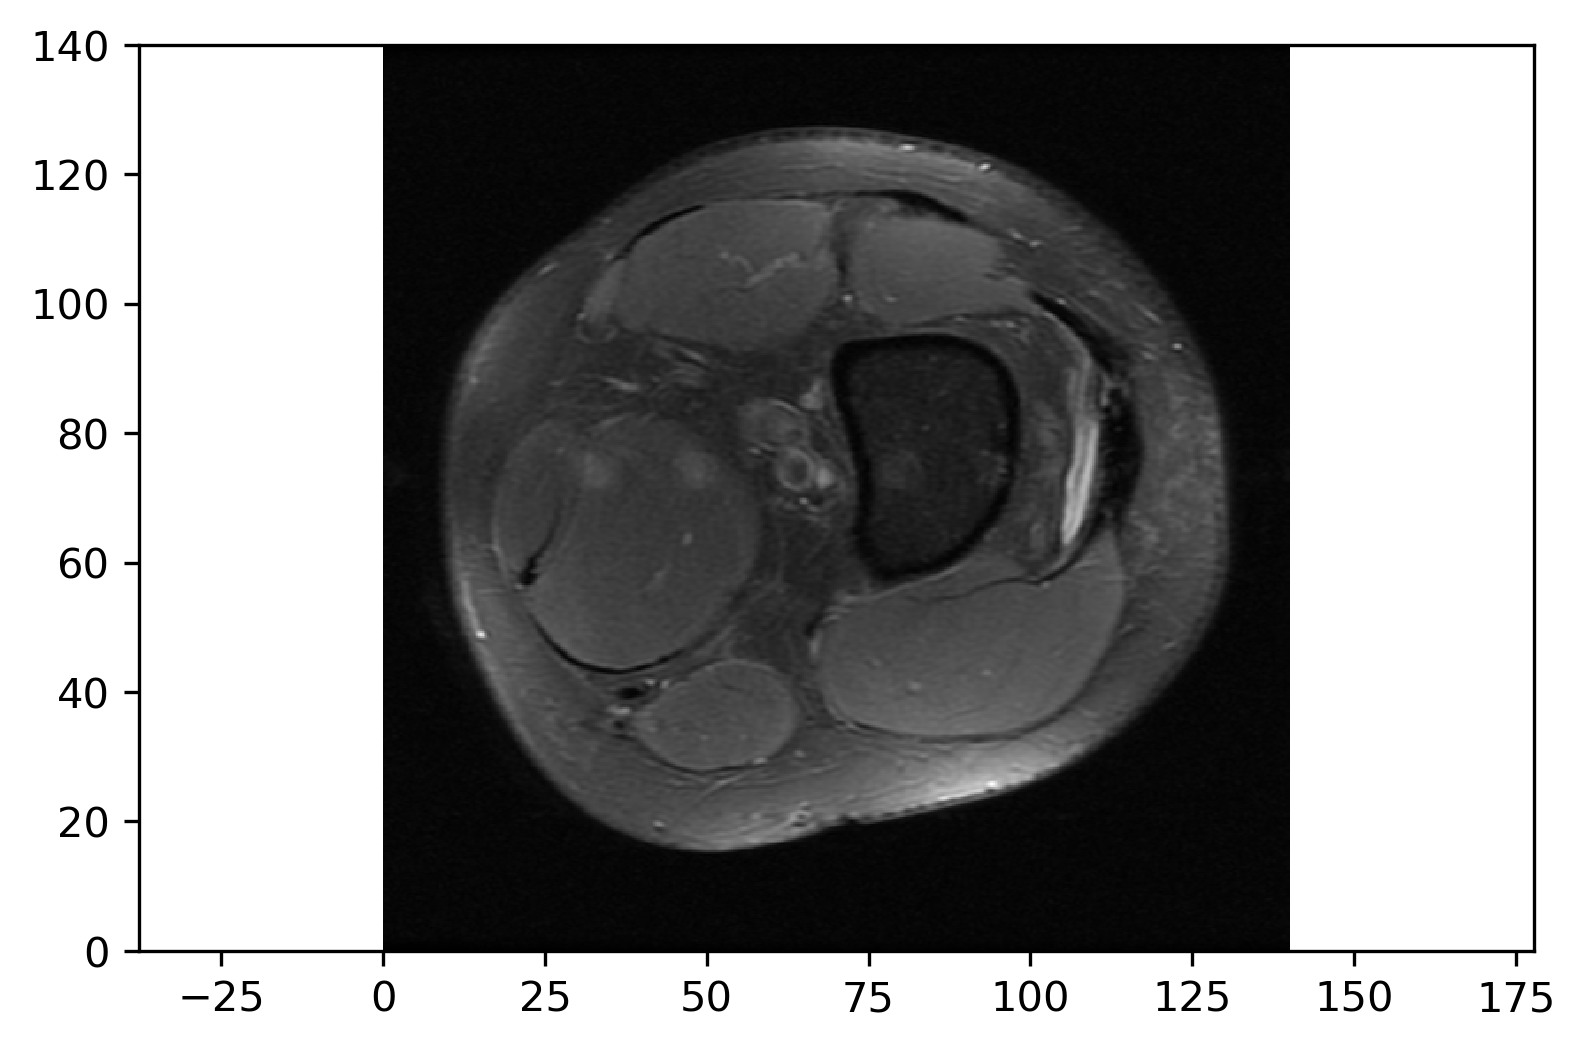

In [44]:
pyplot.figure(dpi=300)
pyplot.axes().set_aspect('equal', 'datalim')
pyplot.set_cmap(pyplot.gray())
pyplot.pcolormesh(x, y, np.flipud(ArrayDicom[:, :, 0]))

In [32]:
PathDicom = "/Users/BlauBear/Documents/HS699/SE000001"
reader = vtk.vtkDICOMImageReader()
reader.SetDirectoryName(PathDicom)
reader.Update()

In [33]:
# Load dimensions using `GetDataExtent`
_extent = reader.GetDataExtent()
ConstPixelDims = [_extent[1]-_extent[0]+1, _extent[3]-_extent[2]+1, _extent[5]-_extent[4]+1]

# Load spacing values
ConstPixelSpacing = reader.GetPixelSpacing()

In [34]:
# Get the 'vtkImageData' object from the reader
imageData = reader.GetOutput()
# Get the 'vtkPointData' object from the 'vtkImageData' object
pointData = imageData.GetPointData()
# Ensure that only one array exists within the 'vtkPointData' object
assert (pointData.GetNumberOfArrays()==1)
# Get the `vtkArray` (or whatever derived type) which is needed for the `numpy_support.vtk_to_numpy` function
arrayData = pointData.GetArray(0)

In [35]:
# Convert the `vtkArray` to a NumPy array
ArrayDicom = numpy_support.vtk_to_numpy(arrayData)
# Reshape the NumPy array to 3D using 'ConstPixelDims' as a 'shape'
ArrayDicom = ArrayDicom.reshape(ConstPixelDims, order='F')

In [36]:
ArrayDicom[:,:,0].shape

(512, 512)

/Users/BlauBear/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


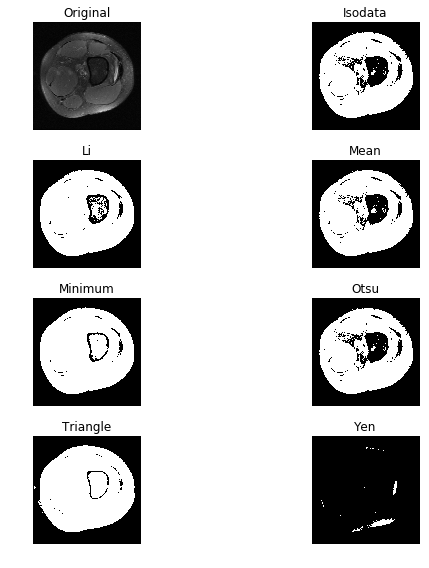

In [37]:
fig, ax = try_all_threshold(ArrayDicom[:,:,0], figsize=(10, 8), verbose=False)
plt.show()

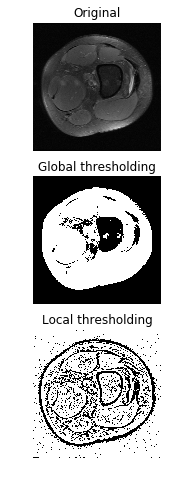

In [38]:
global_thresh = threshold_otsu(ArrayDicom[:,:,0])
binary_global = ArrayDicom[:,:,0] > global_thresh

block_size = 35
local_thresh = threshold_local(ArrayDicom[:,:,0], block_size, offset=10)
binary_local = ArrayDicom[:,:,0] > local_thresh

fig, axes = plt.subplots(nrows=3, figsize=(7, 8))
ax = axes.ravel()
plt.gray()

ax[0].imshow(ArrayDicom[:,:,0])
ax[0].set_title('Original')

ax[1].imshow(binary_global)
ax[1].set_title('Global thresholding')

ax[2].imshow(binary_local)
ax[2].set_title('Local thresholding')

for a in ax:
    a.axis('off')

plt.show()

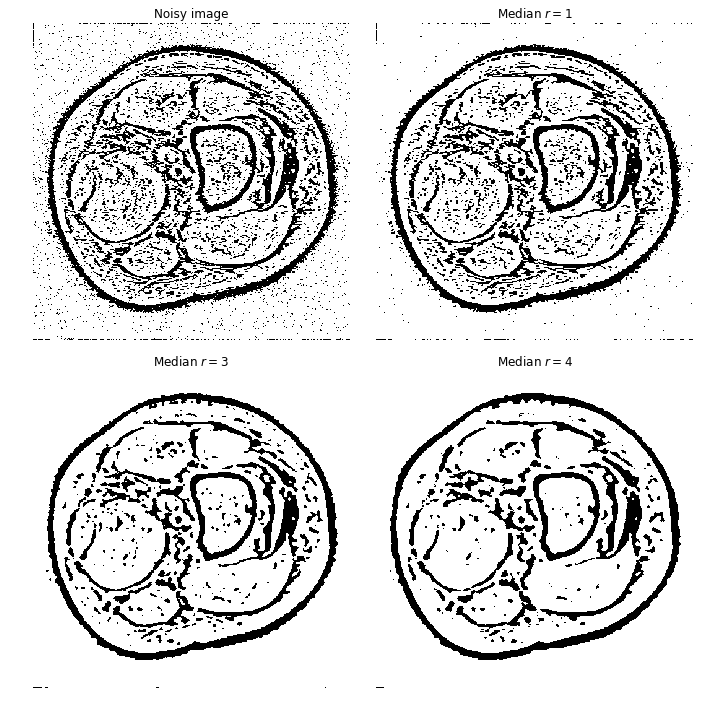

In [39]:
noise = np.random.random(binary_local.shape)
noisy_image = img_as_ubyte(binary_local)
noisy_image[noise > 0.99] = 255
noisy_image[noise < 0.01] = 0

fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(noisy_image, vmin=0, vmax=255, cmap=plt.cm.gray)
ax[0].set_title('Noisy image')

ax[1].imshow(median(noisy_image, disk(1)), vmin=0, vmax=255, cmap=plt.cm.gray)
ax[1].set_title('Median $r=1$')

ax[2].imshow(median(noisy_image, disk(3)), vmin=0, vmax=255, cmap=plt.cm.gray)
ax[2].set_title('Median $r=3$')

ax[3].imshow(median(noisy_image, disk(4)), vmin=0, vmax=255, cmap=plt.cm.gray)
ax[3].set_title('Median $r=4$')

for a in ax:
    a.axis('off')

plt.tight_layout()

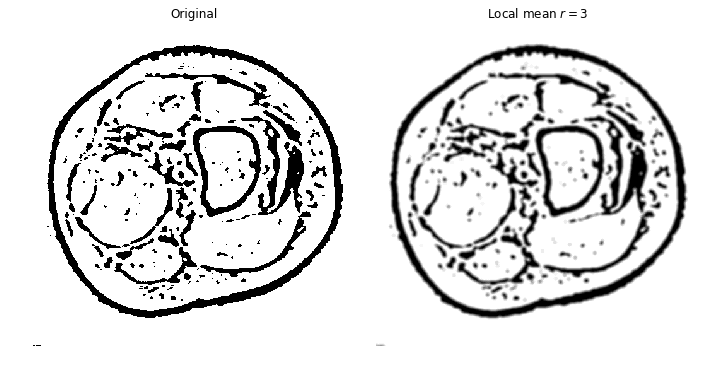

In [40]:
loc_mean = mean(median(noisy_image, disk(4)), disk(3))

fig, ax = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)

ax[0].imshow(median(noisy_image, disk(4)), vmin=0, vmax=255, cmap=plt.cm.gray)
ax[0].set_title('Original')

ax[1].imshow(loc_mean, vmin=0, vmax=255, cmap=plt.cm.gray)
ax[1].set_title('Local mean $r=3$')

for a in ax:
    a.axis('off')

plt.tight_layout()

In [41]:
filtered_img = loc_mean

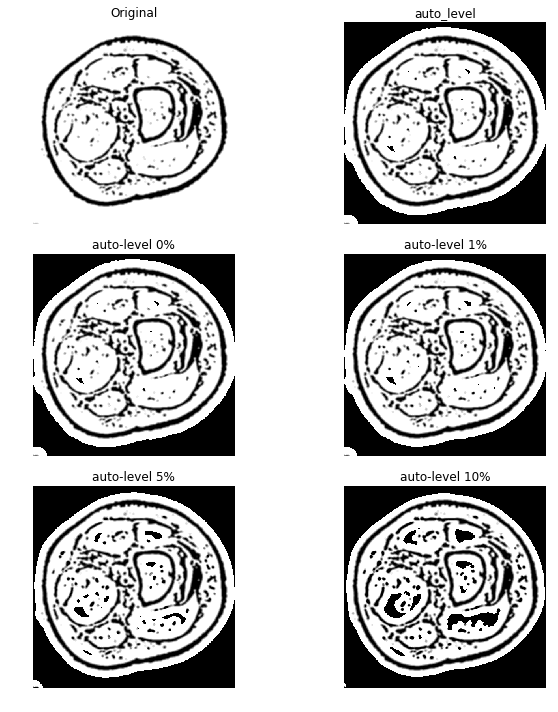

In [42]:
selem = disk(20)
loc_autolevel = autolevel(filtered_img, selem=selem)
loc_perc_autolevel0 = autolevel_percentile(filtered_img, selem=selem, p0=.00, p1=1.0)
loc_perc_autolevel1 = autolevel_percentile(filtered_img, selem=selem, p0=.01, p1=.99)
loc_perc_autolevel2 = autolevel_percentile(filtered_img, selem=selem, p0=.05, p1=.95)
loc_perc_autolevel3 = autolevel_percentile(filtered_img, selem=selem, p0=.1, p1=.9)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10),
                         sharex=True, sharey=True)
ax = axes.ravel()

title_list = ['Original',
              'auto_level',
              'auto-level 0%',
              'auto-level 1%',
              'auto-level 5%',
              'auto-level 10%']
image_list = [filtered_img,
              loc_autolevel,
              loc_perc_autolevel0,
              loc_perc_autolevel1,
              loc_perc_autolevel2,
              loc_perc_autolevel3]

for i in range(0, len(image_list)):
    ax[i].imshow(image_list[i], cmap=plt.cm.gray, vmin=0, vmax=255)
    ax[i].set_title(title_list[i])
    ax[i].axis('off')

plt.tight_layout()

In [43]:
loc_perc_autolevel2

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [46, 65, 44, ...,  0,  0,  0],
       [ 4, 55,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)